<a href="https://colab.research.google.com/github/d-youda/Deep_Learning/blob/main/LSTM_Baseline_and_Bi_dir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import modules and loading the data

In [11]:
# Import libraries
# import gc
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Masking
from tensorflow.keras.layers import Concatenate, Add, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
#데이터 Drive에서 받아오기기
train = pd.read_csv('drive/MyDrive/Deep_learning/football_data/train.csv')
test = pd.read_csv('drive/MyDrive/Deep_learning/football_data/test.csv')
submission = pd.read_csv('drive/MyDrive/Deep_learning/football_data/sample_submission.csv')
len(all_headlines)

0

## Parameters

In [15]:
# Set seed
np.random.seed(123)
tf.random.set_seed(123)
#Set parameters
MASK = -666 # fill NA with -666 (the number of the beast)
T_HIST = 10 # time history, last 10 games
CLASS = 3 #분류 클래스를 3개로 나눔 : home팀이 이긴 경우, 비긴 경우 , away팀이 이긴 경우우
DEBUG = False

# Run on a small sample of the data
if DEBUG:
    train = train[:10000]

In [16]:
#데이터 하나 출력해보기기
print(f"Train: {train.shape} \n Submission: {submission.shape}")
train.head()

Train: (110938, 190) 
 Submission: (72711, 4)


,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


## Feature Engineering

In [17]:
# for cols "date", change to datatime 
for col in train.filter(regex='date', axis=1).columns:
    train[col] = pd.to_datetime(train[col])
    test[col] = pd.to_datetime(test[col])

# Basic feature engineering
def add_features(df):
    for i in range(1, 11): # 1~10
        # Feat. difference of days
        df[f'home_team_history_match_DIFF_day_{i}'] = (df['match_date'] - df[f'home_team_history_match_date_{i}']).dt.days
        df[f'away_team_history_match_DIFF_days_{i}'] = (df['match_date'] - df[f'away_team_history_match_date_{i}']).dt.days

    # Feat. difference of scored goals
        df[f'home_team_history_DIFF_goal_{i}'] = df[f'home_team_history_goal_{i}'] - df[f'home_team_history_opponent_goal_{i}']
        df[f'away_team_history_DIFF_goal_{i}'] = df[f'away_team_history_goal_{i}'] - df[f'away_team_history_opponent_goal_{i}']

    # Results: multiple nested where # away:0, draw:1, home:2
        df[f'home_team_result_{i}'] = np.where(df[f'home_team_history_DIFF_goal_{i}'] > 0, 2,
                         (np.where(df[f'home_team_history_DIFF_goal_{i}'] == 0, 1,
                                   np.where(df[f'home_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
        df[f'away_team_result_{i}'] = np.where(df[f'away_team_history_DIFF_goal_{i}'] > 0, 2,
                         (np.where(df[f'away_team_history_DIFF_goal_{i}'] == 0, 1,
                                   np.where(df[f'away_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))

    # Feat. difference of rating ("modified" ELO RATING)
        df[f'home_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'home_team_history_opponent_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        df[f'away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_opponent_rating_{i}']-df[f'away_team_history_rating_{i}'])/10))
        df[f'home_away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        # df[f'away_team_history_DIFF_rating_{i}'] =  - df[f'away_team_history_opponent_rating_{i}']

    # Feat. same coach id
        df[f'home_team_history_SAME_coaX_{i}'] = np.where(df['home_team_coach_id']==df[f'home_team_history_coach_{i}'],1,0)
        df[f'away_team_history_SAME_coaX_{i}'] = np.where(df['away_team_coach_id']==df[f'away_team_history_coach_{i}'],1,0) 

    # Feat. same league id
        df[f'home_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'home_team_history_league_id_{i}'],1,0)
        df[f'away_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'away_team_history_league_id_{i}'],1,0) 

    # Fill NA with -666
    df.fillna(MASK, inplace = True)
    return df

train = add_features(train)
test = add_features(test)

## Scaling and Reshape

In [18]:
# save targets
# train_id = train['id'].copy()
train_y = train['target'].copy()
#keep only some features
train_x = train.drop(['target', 'home_team_name', 'away_team_name'], axis=1) #, inplace=True) # is_cup EXCLUDED
# Exclude all date, league, coach columns
train_x.drop(train.filter(regex='date').columns, axis=1, inplace = True)
train_x.drop(train.filter(regex='league').columns, axis=1, inplace = True)
train_x.drop(train.filter(regex='coach').columns, axis=1, inplace = True)

# Test set
# test_id = test['id'].copy()
test_x = test.drop(['home_team_name', 'away_team_name'], axis=1)#, inplace=True) # is_cup EXCLUDED

# Exclude all date, league, coach columns
test_x.drop(test.filter(regex='date').columns, axis=1, inplace = True)
test_x.drop(test.filter(regex='league').columns, axis=1, inplace = True)
test_x.drop(test.filter(regex='coach').columns, axis=1, inplace = True)

In [19]:
# Target, train and test shape
print(f"Target: {train_y.shape} \n Train shape: {train_x.shape} \n Test: {test_x.shape}")
print(f"Column names: {list(train_x.columns)}")

Target: (110938,) 
 Train shape: (110938, 252) 
 Test: (72711, 252)
Column names: ['id', 'is_cup', 'home_team_history_is_play_home_1', 'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3', 'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5', 'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7', 'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9', 'home_team_history_is_play_home_10', 'home_team_history_is_cup_1', 'home_team_history_is_cup_2', 'home_team_history_is_cup_3', 'home_team_history_is_cup_4', 'home_team_history_is_cup_5', 'home_team_history_is_cup_6', 'home_team_history_is_cup_7', 'home_team_history_is_cup_8', 'home_team_history_is_cup_9', 'home_team_history_is_cup_10', 'home_team_history_goal_1', 'home_team_history_goal_2', 'home_team_history_goal_3', 'home_team_history_goal_4', 'home_team_history_goal_5', 'home_team_history_goal_6', 'home_team_history_goal_7', 'home_team_history_goal_8', 'home_team_hist

In [20]:
train_x.head()

,id,is_cup,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,...,away_team_history_DIFF_goal_10,home_team_result_10,away_team_result_10,home_team_history_ELO_rating_10,away_team_history_ELO_rating_10,home_away_team_history_ELO_rating_10,home_team_history_SAME_coaX_10,away_team_history_SAME_coaX_10,home_team_history_SAME_leaG_10,away_team_history_SAME_leaG_10
0,11906497,False,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,2.0,2.0,2.0,0.698653,0.570885,0.567616,1,1,1,0
1,11984383,False,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,3.0,1.0,2.0,0.711318,0.204827,0.718473,1,1,1,1
2,11983301,False,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.587305,0.805052,0.281921,1,1,1,1
3,11983471,False,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,-1.0,1.0,0.0,0.691667,0.368863,0.642603,1,1,1,1
4,11883005,False,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.801097,0.347241,0.785462,1,0,1,1


In [29]:
# Store feature names
# feature_names = list(train.columns)
# Pivot dataframe to create an input array for the LSTM network
feature_groups = ["home_team_history_is_play_home", "home_team_history_is_cup",
    "home_team_history_goal", "home_team_history_opponent_goal",
    "home_team_history_rating", "home_team_history_opponent_rating",  
    "away_team_history_is_play_home", "away_team_history_is_cup",
    "away_team_history_goal", "away_team_history_opponent_goal",
    "away_team_history_rating", "away_team_history_opponent_rating",  
    "home_team_history_match_DIFF_day", "away_team_history_match_DIFF_days",
    "home_team_history_DIFF_goal","away_team_history_DIFF_goal",
    "home_team_history_ELO_rating","away_team_history_ELO_rating",
    "home_away_team_history_ELO_rating",
    "home_team_history_SAME_coaX", "away_team_history_SAME_coaX",
    "home_team_history_SAME_leaG", "away_team_history_SAME_leaG",
    "home_team_result", "away_team_result"]      
# Pivot dimension (id*features) x time_history
train_x_pivot = pd.wide_to_long(train_x, stubnames=feature_groups, 
                i=['id','is_cup'], j='time', sep='_', suffix='\d+')
test_x_pivot = pd.wide_to_long(test_x, stubnames=feature_groups, 
                i=['id','is_cup'], j='time', sep='_', suffix='\d+')
#
print(f"Train pivot shape: {train_x_pivot.shape}")  
print(f"Test pivot shape: {test_x_pivot.shape}") 

Train pivot shape: (1109380, 25)
Test pivot shape: (727110, 25)


In [30]:
# create columns based on index
train_x_pivot = train_x_pivot.reset_index()
test_x_pivot = test_x_pivot.reset_index()
# Deal with the is_cup feature
# There are na in 'is_cup'
train_x_pivot=train_x_pivot.fillna({'is_cup':False})
#train_x_pivot['is_cup'] = pd.get_dummies(train_x_pivot['is_cup'], drop_first=True)
df = pd.DataFrame(data=['type1', 'type2', 'type3'] , columns=['is_cup'])
dummies_df = pd.get_dummies(df['is_cup'])
pd.concat([df, dummies_df], axis=1)

test_x_pivot=test_x_pivot.fillna({'is_cup':False})
test_x_pivot['is_cup']= pd.get_dummies(test_x_pivot['is_cup'], drop_first=True)

In [31]:
train_x_pivot.head(20)

,id,is_cup,time,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,home_team_history_rating,home_team_history_opponent_rating,away_team_history_is_play_home,...,away_team_history_DIFF_goal,home_team_history_ELO_rating,away_team_history_ELO_rating,home_away_team_history_ELO_rating,home_team_history_SAME_coaX,away_team_history_SAME_coaX,home_team_history_SAME_leaG,away_team_history_SAME_leaG,home_team_result,away_team_result
0,11906497,False,1,0.0,0.0,0.0,1.0,3.856860,5.199840,0.0,...,-1.0,0.423302,0.462354,0.457440,1,1,1,0,0.0,0.0
1,11906497,False,2,1.0,0.0,2.0,0.0,5.724370,3.694033,1.0,...,2.0,0.614792,0.888312,0.197047,1,1,1,0,2.0,2.0
2,11906497,False,3,0.0,0.0,0.0,1.0,4.335091,5.131156,1.0,...,-1.0,0.454303,0.808676,0.238585,1,1,1,1,0.0,0.0
3,11906497,False,4,1.0,0.0,0.0,4.0,6.678853,3.193161,0.0,...,1.0,0.690533,0.758992,0.409659,1,1,1,1,0.0,2.0
4,11906497,False,5,0.0,0.0,3.0,1.0,5.478300,4.080169,1.0,...,1.0,0.579795,0.868420,0.228225,1,1,1,1,2.0,2.0
5,11906497,False,6,1.0,0.0,0.0,0.0,5.858534,3.898775,0.0,...,-1.0,0.610937,0.430964,0.567409,1,1,1,0,1.0,0.0
6,11906497,False,7,0.0,0.0,1.0,1.0,3.641945,7.672377,0.0,...,0.0,0.283322,0.605444,0.344807,1,1,1,1,1.0,1.0
7,11906497,False,8,1.0,0.0,2.0,0.0,7.957243,2.864026,1.0,...,2.0,0.763643,0.907745,0.248081,1,1,1,0,2.0,2.0
8,11906497,False,9,0.0,0.0,1.0,1.0,4.326252,4.814193,1.0,...,2.0,0.471941,0.860812,0.177999,1,1,1,1,1.0,2.0
9,11906497,False,10,1.0,0.0,4.0,1.0,7.106259,3.454310,1.0,...,2.0,0.698653,0.570885,0.567616,1,1,1,0,2.0,2.0


In [32]:
test_x_pivot.head(20)

,id,is_cup,time,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,home_team_history_rating,home_team_history_opponent_rating,away_team_history_is_play_home,...,away_team_history_DIFF_goal,home_team_history_ELO_rating,away_team_history_ELO_rating,home_away_team_history_ELO_rating,home_team_history_SAME_coaX,away_team_history_SAME_coaX,home_team_history_SAME_leaG,away_team_history_SAME_leaG,home_team_result,away_team_result
0,17761448,0,1,0.0,1.0,0.0,0.0,4.134982,7.460100,1.0,...,0.0,0.317424,0.575257,0.392121,1,1,0,1,1.0,1.0
1,17761448,0,2,0.0,0.0,3.0,0.0,5.579979,6.035358,0.0,...,-1.0,0.473810,0.363154,0.561026,1,1,1,1,2.0,0.0
2,17761448,0,3,1.0,1.0,1.0,0.0,4.604694,7.761637,1.0,...,0.0,0.325872,0.381537,0.509626,1,1,0,1,2.0,1.0
3,17761448,0,4,1.0,0.0,1.0,1.0,4.405645,6.151000,0.0,...,-3.0,0.400860,0.431775,0.489390,1,1,1,1,1.0,0.0
4,17761448,0,5,0.0,0.0,2.0,2.0,3.802064,10.470336,0.0,...,-2.0,0.177201,0.292448,0.505769,1,1,1,1,1.0,0.0
5,17761448,0,6,0.0,1.0,0.0,0.0,4.641138,7.210415,1.0,...,2.0,0.356268,0.289094,0.506911,1,1,0,1,1.0,2.0
6,17761448,0,7,0.0,0.0,2.0,0.0,4.703983,6.590811,1.0,...,0.0,0.393062,0.502916,0.484525,1,1,1,1,2.0,1.0
7,17761448,0,8,0.0,0.0,1.0,1.0,4.218740,7.822580,0.0,...,1.0,0.303684,0.301651,0.561167,1,1,1,1,1.0,2.0
8,17761448,0,9,1.0,1.0,0.0,0.0,4.382131,7.530525,1.0,...,1.0,0.326305,0.680105,0.349246,1,1,0,1,1.0,2.0
9,17761448,0,10,1.0,0.0,0.0,2.0,5.234275,7.054200,0.0,...,-1.0,0.396743,0.408056,0.507374,1,1,1,1,0.0,0.0


In [34]:
x_train = train_x_pivot.drop(['id', 'time'], axis=1)
x_test = test_x_pivot.drop(['id', 'time'], axis=1)
# Scale features using statistics that are robust to outliers
RS = RobustScaler()
x_train = RS.fit_transform(x_train)
x_test = RS.transform(x_test)
# Fill NA with MASK
x_train = np.nan_to_num(x_train, nan=MASK)
x_test = np.nan_to_num(x_test, nan=MASK)
# Reshape 
x_train = x_train.reshape(-1, T_HIST, x_train.shape[-1])
x_test = x_test.reshape(-1, T_HIST, x_test.shape[-1])
# Back to pandas.dataframe
x_train = pd.DataFrame(train, columns=feature_names)
x_train = pd.concat([train_id, x_train], axis = 1)
x_test = pd.DataFrame(test, columns=feature_names)
x_test = pd.concat([test_id, x_test], axis = 1)

NameError: ignored

In [ ]:
# Input array for the LSTM network
# Dimension (MATCHES, TIME, FEATURES)
# INV = False
'''if False:
    # Trying to keep the same id order
    x_train = pd.merge(train_id, x_train_pivot, on="id")
    x_train = x_train.drop(['id'], axis = 1).to_numpy().reshape(-1, T_HIST, x_train_pivot.shape[-1])
    # Test
    x_test = pd.merge(test_id, x_test_pivot, on="id")
    x_test = x_test.drop(['id'], axis = 1).to_numpy().reshape(-1, T_HIST, x_test_pivot.shape[-1])
'''
## Replacing it with bi-directional LSTM

In [35]:
# Changing the sequence of time from 1...10 to 10...1 improve the model?
# bidirectional LSTM is used

if False:
    # Trying to keep the same id order
    x_train_pivot = x_train_pivot.reset_index()
    x_train_pivot['time'] = (T_HIST + 1) - x_train_pivot['time']
    x_train_pivot.sort_values(by=['time'], inplace = True)
    # Merge and drop columns
    x_train = pd.merge(train_id, x_train_pivot, on="id").drop(['id', 'time'], axis = 1)
    x_train = x_train.to_numpy().reshape(-1, T_HIST, x_train.shape[-1])
    # Test
    x_test_pivot = x_test_pivot.reset_index()
    x_test_pivot['time'] = (T_HIST + 1) - x_test_pivot['time']
    x_test_pivot.sort_values(by=['time'], inplace = True)
    x_test = pd.merge(test_id, x_test_pivot, on="id").drop(['id', 'time'], axis = 1)
    x_test = x_test.to_numpy().reshape(-1, T_HIST, x_test.shape[-1])

In [36]:
print(f"Train array shape: {x_train.shape} \nTest array shape: {x_test.shape}")

Train array shape: (110938, 10, 26) 
Test array shape: (72711, 10, 26)


In [37]:
# Deal with targets
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_y = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_y)
# 
print(encoded_y.shape)
print(dummy_y.shape)
# encoding away: 0 draw: 1 home: 2 
print(encoded_y[:10,])
# Order: away, draw, home
print(dummy_y[:10,])

(110938,)
(110938, 3)
[0 2 1 0 2 1 2 0 2 2]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


## Make a model

In [38]:
# Huge LSTM model -> No good
# RNN : A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. 
# Here the model will accumulate internal state for 10 matches, before making a single prediction for the next match.
def model_1():
    x_input = Input(shape=(x_train.shape[-2:]))
    #x1 = layers.Masking(mask_value=MASK)(x_input)
    #
    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(x2)
    x4 = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x1)
    x5 = layers.Bidirectional(layers.LSTM(units=32, return_sequences=True))(x4)
    z2 = Bidirectional(GRU(units=256, return_sequences=True))(x2)
    z3 = Bidirectional(GRU(units=128, return_sequences=True))(Add()([x3, z2]))
    x = Concatenate(axis=2)([x3, z2, z3])
    x = Bidirectional(LSTM(units=192, return_sequences=True))(x)
    x = layers.Flatten()(x5)
    x = layers.Dense(units=16, activation='selu')(x)
     # Output layer must create 3 output values, one for each class.
    # Activation function is softmax for multi-class classification.
    x_output = layers.Dense(units=CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input], outputs=[x_output])
    return model

In [39]:
# This is similar to the model of "igorkf"
def model_2():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.Masking(mask_value=MASK, input_shape=(x_train.shape[1:]))(x_input)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)  
    x = layers.Bidirectional(layers.LSTM(8, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    # output
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])
    return model

In [40]:
# standard LSTM model -> Not bad
def model_3():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.Masking(mask_value=MASK, input_shape=(x_train.shape[1:]))(x_input)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Bidirectional(layers.LSTM(8))(x) #ATTENTION: return sequences False, no Flatten layer
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu')(x)
    # Output layer must create 3 output values, one for each class.
    # Activation function is softmax for multi-class classification.
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])
    return model

In [41]:
# CNN A convolutional model makes predictions based on a fixed-width history, 
# which may lead to better performance than the dense model since it can see how things are changing over time:
CONV_WIDTH = 10

def model_4():
    x_input = layers.Input(shape=x_train.shape[1:])
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    x = layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH))(x_input)
    x = layers.Dense(16, activation = 'relu')(x)
    # Output layer must create 3 output values, one for each class.
    # Activation function is softmax for multi-class classification.
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])
    return model

In [42]:
#Simple convnet
MAX_POOL = 2
def model_5():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.Conv1D(32, kernel_size = CONV_WIDTH, activation="relu")(x_input)
    # x = layers.MaxPooling1D(pool_size = MAX_POOL, padding='same')(x)
    x = layers.Conv1D(16, kernel_size = CONV_WIDTH, activation="relu")(x)
    x = layers.MaxPooling1D(pool_size = MAX_POOL, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])

    return model

In [43]:
def model_6():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.ConvLSTM1D(32,kernel_size=CONV_WIDTH,padding="same",return_sequences=True,activation="relu")(x_input)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM1D(16,kernel_size=CONV_WIDTH,padding="same",return_sequences=True,activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])

    return model

In [44]:
# Choose your model
model = model_2()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 26)]          0         
                                                                 
 masking (Masking)           (None, 10, 26)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 32)           5504      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 16)           2624      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 16)            0     

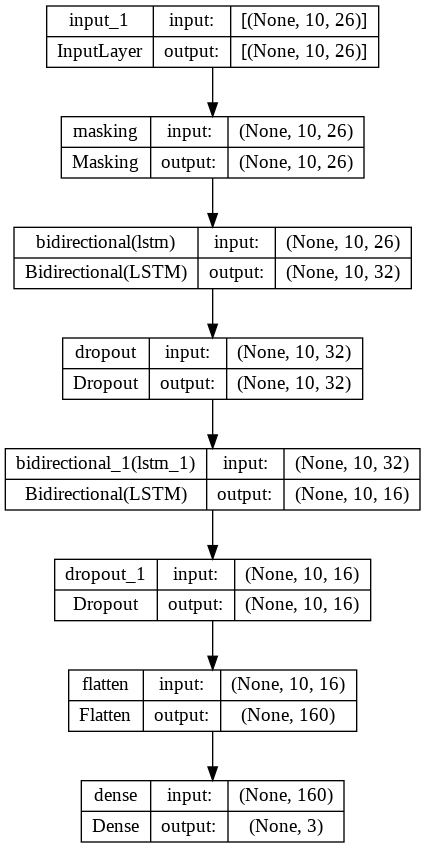

In [45]:
plot_model(
    model, 
    to_file='Football_Prob_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [46]:
# Just one fold, validation split = 20%

EPOCH = 300
BATCH_SIZE = 512
N_SPLITS = 5
SEED = 123
VERBOSE = 1
PATIENCE = EPOCH // 10
VAL_SPLIT = 0.2
# Model
# It is a multi-class classification problem, categorical_crossentropy is used as the loss function.
model.compile(optimizer="adam", loss="categorical_crossentropy",
                 metrics=["accuracy"])
#
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=0, mode='min',restore_best_weights=True)
scheduler = ExponentialDecay(3e-3, 40*((len(x_train))/BATCH_SIZE), 1e-4)
lr = LearningRateScheduler(scheduler, verbose = 0)
#
model.fit(x_train, dummy_y, 
              # validation_data=(x_train, y_train), 
              validation_split=VAL_SPLIT,
              epochs=EPOCH,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE,
              callbacks=[lr, es])

Epoch 1/300
174/174 [==============================] - 36s 110ms/step - loss: 1.0273 - accuracy: 0.4866 - val_loss: 1.0090 - val_accuracy: 0.4970 - lr: 0.0030
Epoch 2/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0142 - accuracy: 0.4976 - val_loss: 1.0075 - val_accuracy: 0.4991 - lr: 0.0030
Epoch 3/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0115 - accuracy: 0.4990 - val_loss: 1.0048 - val_accuracy: 0.5005 - lr: 0.0030
Epoch 4/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0099 - accuracy: 0.5010 - val_loss: 1.0039 - val_accuracy: 0.5002 - lr: 0.0030
Epoch 5/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0082 - accuracy: 0.5007 - val_loss: 1.0044 - val_accuracy: 0.4999 - lr: 0.0030
Epoch 6/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0076 - accuracy: 0.5020 - val_loss: 1.0051 - val_accuracy: 0.4993 - lr: 0.0030
Epoch 7/300
174/174 [==============================

## Fit the model and a make submission

In [ ]:
# N_SPLITS of the traning set for validation using KFold
# Parameters
EPOCH = 300
BATCH_SIZE = 512
N_SPLITS = 5
SEED = 123
VERBOSE = 1
PATIENCE = EPOCH // 10

test_preds = []

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(x_train, dummy_y)):
    print('-'*15, '>', f'Fold {fold+1}/{N_SPLITS}', '<', '-'*15)
    X_train, X_valid = x_train[train_idx], x_train[test_idx]
    Y_train, Y_valid = dummy_y[train_idx], dummy_y[test_idx]
    # Model
    model = model_2()
    # It is a multi-class classification problem, categorical_crossentropy is used as the loss function.
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                 metrics=["accuracy"])
    #
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=0, mode='min',
                       restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=0)
    #
    model.fit(X_train, Y_train, 
              validation_data=(X_valid, Y_valid), 
              epochs=EPOCH,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE,  
              callbacks=[lr, es])
    # Model validation    
    y_true = Y_valid.squeeze()
    y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze()
    score1 = log_loss(y_true, y_pred)
    print(f"Fold-{fold+1} | OOF LogLoss Score: {score1}")
    # Predictions
    test_preds.append(model.predict(x_test).squeeze())
    # test_preds.append(model.predict(x_test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

--------------- > Fold 1/5 < ---------------
Epoch 1/300
174/174 [==============================] - 33s 98ms/step - loss: 1.0418 - accuracy: 0.4683 - val_loss: 1.0136 - val_accuracy: 0.4982 - lr: 0.0010
Epoch 2/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0220 - accuracy: 0.4898 - val_loss: 1.0106 - val_accuracy: 0.4998 - lr: 0.0010
Epoch 3/300
174/174 [==============================] - 11s 64ms/step - loss: 1.0171 - accuracy: 0.4942 - val_loss: 1.0096 - val_accuracy: 0.5004 - lr: 0.0010
Epoch 4/300
174/174 [==============================] - 11s 63ms/step - loss: 1.0140 - accuracy: 0.4956 - val_loss: 1.0080 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 5/300
174/174 [==============================] - 11s 63ms/step - loss: 1.0128 - accuracy: 0.4967 - val_loss: 1.0076 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 6/300
174/174 [==============================] - 12s 66ms/step - loss: 1.0114 - accuracy: 0.4984 - val_loss: 1.0077 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 7

In [48]:
predictions = sum(test_preds)/N_SPLITS 

# away, draw, home
submission = pd.DataFrame(predictions,columns=['away', 'draw', 'home'])

#do not forget the id column
submission['id'] = test[['id']]

#submit!
submission[['id', 'home', 'away', 'draw']].to_csv('submission.csv', index=False)

In [49]:
submission[['id', 'home', 'away', 'draw']].head()

,id,home,away,draw
0,17761448,0.474398,0.229142,0.296459
1,17695487,0.359245,0.339609,0.301146
2,17715496,0.391200,0.306010,0.302790
3,17715493,0.167136,0.571356,0.261507
4,17715492,0.484770,0.217786,0.297444
